<a href="https://colab.research.google.com/github/aerjayc/CoE197Z/blob/master/cat_in_the_dat_formatted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Downloading the dataset

In [2]:
!git clone https://github.com/aerjayc/CoE197Z.git
!cp "CoE197Z/train.csv" .
!cp "CoE197Z/test.csv" .
!cp "CoE197Z/sample_submission.csv" .
!ls

Cloning into 'CoE197Z'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 10), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (32/32), done.
CoE197Z  sample_data  sample_submission.csv  test.csv  train.csv


---

### Importing the dataset

In [166]:
import pandas as pd

# import train data)
data = pd.read_csv("train.csv")
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


### Structure of the data:

* __`id`__ : unique integer associated with each entry
* __`bin_*`__ : binary values
* __`nom_*`__ : _unordered_ values
* __`ord_*`__ : _ordered_ values
* __`day`__ $\in \{ 1, 2, 3, ..., 7 \}$
* __`month`__ $\in \{ 1, 2, 3, ..., 12  \}$
* __`target`__ $\in \{0,1\}$
    * the value we want to predict

## Preprocessing the data

###Binary Data

* `bin_*` : binary values
    * `bin_{0-2}` $\in \{0,1\}$
        * already in 1-hot encoding
    * `bin_3` $\in \{T,F\}$
        * remap $\ T \to 1,\ F \to 0$
    * `bin_4`: $\in \{Y,N\}$
        * remap $\ Y \to 1,\ N \to 0$

In [167]:
# Binary Data

## Arbitrary binary data to 1's and 0's
def bin_to_10(np_array, one='T', zero='F'):
    np_array[np_array == one]  = 1
    np_array[np_array == zero] = 0
    """ Q: Why is there no return value?
        A: np arrays are passed by reference, so modifying them in a function
           also modifies them outside """

bin_to_10(data['bin_3'].to_numpy(), one='T', zero='F')
bin_to_10(data['bin_4'].to_numpy(), one='Y', zero='N')
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,1,1,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,1,1,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,0,1,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,0,1,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,0,0,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


### Nominal Data

* __`nom_*`__ : _unordered_ values
    * __`nom_0`__ : 3 unique values (colors)
    * __`nom_1`__ : 6 unique values (shapes)
    * __`nom_2`__ : 6 unique values (animals)
    * __`nom_3`__ : 6 unique values (countries)
    * __`nom_4`__ : 4 unique values (instruments)
    * __`nom_5`__ : 222 unique values   (hex)
    * __`nom_6`__ : 522 unique values   (hex)
    * __`nom_7`__ : 1220 unique values  (hex)
    * __`nom_8`__ : 2215 unique values  (hex)
    * __`nom_9`__ : 11981 unique values (hex)

These can be easily converted into 1-hot encoding.
To reduce the load, maybe we can take the most frequently appearing values only? like top 1000 values or something...

In [168]:
# Nominal Data
for i in range(6):  # skip nom_9 for now...
    data = pd.get_dummies(data, columns=[f'nom_{i}'], prefix = [f'nom_{i}'])
    """ Each nom_* column is transformed into a 1-hot vector

        E.g.: nom_0 has 3 distinct categories: 'Red', 'Green', 'Blue'. 1-hot
              encoding turns it into 3 columns consisting of only 1's and 0's
              so that:
                    nom_0 = ['Green', 'Green', 'Blue', 'Red', ...]
              becomes 3 columns:
                    nom_0_Blue  = [1, 1, 0, 0, ...]
                    nom_0_Green = [0, 0, 1, 0, ...]
                    nom_0_Red   = [0, 0, 0, 1, ...] """
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,...,nom_5_dbc448931,nom_5_dbfb714a4,nom_5_dc07effb0,nom_5_dd500b26a,nom_5_ddac78300,nom_5_de04b8750,nom_5_defc6dd20,nom_5_df51b96fc,nom_5_e08092732,nom_5_e0efe9d20,nom_5_e1558b071,nom_5_e428c040e,nom_5_e52fbf1c8,nom_5_e5b29c42b,nom_5_e6f45aa26,nom_5_e70a6270d,nom_5_e7d9ca356,nom_5_e844a1f66,nom_5_e85ec20b5,nom_5_e9c6fe0f7,nom_5_e9f44a509,nom_5_ead12da87,nom_5_eb0004a0b,nom_5_eb69430d6,nom_5_ee55b9d67,nom_5_ef38568df,nom_5_f0c1ceee4,nom_5_f12246592,nom_5_f2a6d797b,nom_5_f2d59cf51,nom_5_f50eb07ae,nom_5_f6c524860,nom_5_f710fca39,nom_5_f7821e391,nom_5_f802a9849,nom_5_f8faea16f,nom_5_f9d17bb93,nom_5_f9e5266f9,nom_5_fa0a88fe9,nom_5_fd04a970f
0,0,0,0,0,1,1,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,1,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,1,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Ordinal Data

* __`ord_*`__ : _ordered_ values
    * __`ord_0`__ $\in \{ 1, 2, 3 \}$
    * __`ord_1`__ $\in \{$ `Novice`, `Contributor`, `Expert`, `Master`, `Grandmaster` $\}$
    * __`ord_2`__ $\in \{$ `Freezing`, `Cold`, `Warm`, `Hot`, `Boiling Hot`, `Lava Hot` $\}$
    * __`ord_3`__ : 15 unique values (lowercase letters)
    * __`ord_4`__ : 26 unique values (uppercase letters)
    * __`ord_5`__ : 192 unique values (two-letter combinations)

* From the `cat-in-the-dat` page [here](https://www.kaggle.com/c/cat-in-the-dat/data):
    * "The string ordinal features `ord_{3-5}` are lexically ordered according to `string.ascii_letters`."
        * where the order of `string.ascii_letters` = `'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'`

* This should be manually labeled according to their rank (e.g. `Freezing < Cold < Warm < ...`), then normalized to have a range of $[0,1]$ (or maybe some more sophisticated method? IIRC there are some normalizers that normalize both mean and variance, not just the min and max values. This is useful for columns with outlier values. Not sure if we have any outliers though. It would be useful if we had a histogram of each of the columns just so we have an idea of their distributions. see https://stats.stackexchange.com/questions/207108/rescaling-vs-standardization-of-features)

In [169]:
# Ordinal Data

## Arbitrary categorical data to integers
def ord_to_int(np_array, categories, values=None, normalize=True):
    """ np_array: the column vector.
        categories: a list/tuple containing the distinct elements in np_array
        values: a list/tuple with the same length as categories. It contains the
                values to be assigned to the corresponding category.
                By default, values = [0, 1, 2, ..., len(categories)-1]
        normalize: a boolean value. Default value is True.
                   If True, the output is scaled so that its range is [0,1].
        E.g.: For the following inputs:
                    np_array = array(['c', 'a', 'd', 'b', 'c'])
                    categories =  ['a', 'b', 'c', 'd']
                    values =      [ 0 ,  1 ,  2 ,  3 ]
              np_array becomes:
                    np_array = array([2, 0, 3, 1, 2])
        Note: this is the generalized version of bin_to_10:
                bin_to_10(np_array) = nom_to_int(np_array, ['T','F']) """

    if (not values) or (len(values) != len(categories)) :
        values = list(range(len(categories)))

    for i in range(len(categories)):
        np_array[np_array == categories[i]] = values[i]
    
    if normalize:
        from sklearn.preprocessing import MinMaxScaler
        np_array = MinMaxScaler().fit_transform(np_array.reshape(-1,1))
    
    return np_array

categories = ('Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster')
data['ord_1'] = ord_to_int(data['ord_1'].to_numpy(), categories)

categories = ('Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot')
data['ord_2'] = ord_to_int(data['ord_2'].to_numpy(), categories)

categories = data['ord_3'].astype('category').cat.categories.tolist()
data['ord_3'] = ord_to_int(data['ord_3'].to_numpy(), sorted(categories))

categories = data['ord_4'].astype('category').cat.categories.tolist()
data['ord_4'] = ord_to_int(data['ord_4'].to_numpy(), sorted(categories))

# https://stackoverflow.com/a/28136444
categories = data['ord_5'].astype('category').cat.categories.tolist()
data['ord_5'] = ord_to_int(data['ord_5'].to_numpy(), sorted(categories, key=str.swapcase))

"""
### Normalize data so it has a range of [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)"""

data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,...,nom_5_dbc448931,nom_5_dbfb714a4,nom_5_dc07effb0,nom_5_dd500b26a,nom_5_ddac78300,nom_5_de04b8750,nom_5_defc6dd20,nom_5_df51b96fc,nom_5_e08092732,nom_5_e0efe9d20,nom_5_e1558b071,nom_5_e428c040e,nom_5_e52fbf1c8,nom_5_e5b29c42b,nom_5_e6f45aa26,nom_5_e70a6270d,nom_5_e7d9ca356,nom_5_e844a1f66,nom_5_e85ec20b5,nom_5_e9c6fe0f7,nom_5_e9f44a509,nom_5_ead12da87,nom_5_eb0004a0b,nom_5_eb69430d6,nom_5_ee55b9d67,nom_5_ef38568df,nom_5_f0c1ceee4,nom_5_f12246592,nom_5_f2a6d797b,nom_5_f2d59cf51,nom_5_f50eb07ae,nom_5_f6c524860,nom_5_f710fca39,nom_5_f7821e391,nom_5_f802a9849,nom_5_f8faea16f,nom_5_f9d17bb93,nom_5_f9e5266f9,nom_5_fa0a88fe9,nom_5_fd04a970f
0,0,0,0,0,1,1,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,1.0,0.2,0.500000,0.12,0.225131,2,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,1.0,0.6,0.000000,0.00,0.036649,7,8,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,1,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,0.5,1.0,0.500000,0.68,0.706806,7,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,1,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,1.0,0.8,0.571429,0.12,0.261780,2,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,1.0,0.0,0.000000,0.68,0.387435,7,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



* `Day` and `Month`
    * I don't know how to deal with this yet. They aren't independent, so we shouldn't process them separately. (Maybe we could, idk. Thoughts?)

In [0]:
from sklearn.preprocessing import MinMaxScaler
data['day'] = MinMaxScaler().fit_transform(data['day'].to_numpy().reshape(-1,1))
data['month'] = MinMaxScaler().fit_transform(data['month'].to_numpy().reshape(-1,1))

In [172]:
y_train = data['target'].to_numpy().astype('float32')

# make this more efficient!
x_train = data.drop(columns=['id', 'target', 'nom_6', 'nom_7', 'nom_8', 'nom_9'])
x_train = x_train.to_numpy().astype('float32')

N = 300000
#x_train = x_train[:N]
#y_train = y_train[:N]

x_train.shape

(300000, 260)

In [173]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras import optimizers

# hyperparameters

hidden_units = 1024
output_units = 1
_, input_dim = x_train.shape
batch_size   = 512
dropout_rate = 0
l2_weight    = 0

kernel_regularizer = regularizers.l2(l2_weight)
optimizer = optimizers.RMSprop()

epochs = 50
validation_split = 0.2

###Model
model = Sequential()

model.add(Dense(hidden_units, input_dim=input_dim))
model.add(Activation('relu'))
#model.add(Dropout(dropout_rate))

model.add(Dense(hidden_units))
model.add(Activation('relu'))
#model.add(Dropout(dropout_rate))

model.add(Dense(hidden_units))
model.add(Activation('relu'))
#model.add(Dropout(dropout_rate))

model.add(Dense(hidden_units))
model.add(Activation('relu'))
#model.add(Dropout(dropout_rate))
"""
model.add(Dense(hidden_units))
model.add(Activation('relu'))
#model.add(Dropout(dropout_rate))

model.add(Dense(hidden_units))
model.add(Activation('relu'))
#model.add(Dropout(dropout_rate))
"""
model.add(Dense(output_units, activation='sigmoid'))

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_296 (Dense)            (None, 1024)              267264    
_________________________________________________________________
activation_235 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_297 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
activation_236 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_298 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
activation_237 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_299 (Dense)            (None, 1024)            

In [174]:
import numpy as np
rng_state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(rng_state)
np.random.shuffle(y_train)

# checkpoint
#from keras.callbacks import ModelCheckpoint
#filepath="weights.best.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks = [checkpoint]
# early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(verbose=1)
callbacks = []

history = model.fit(x_train, y_train, validation_split=validation_split,
                    epochs=epochs, batch_size=batch_size,
                    callbacks=callbacks)

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 14s 60us/step - loss: 0.5493 - acc: 0.7298 - val_loss: 0.5300 - val_acc: 0.7330
Epoch 2/50
240000/240000 [==============================] - 10s 40us/step - loss: 0.5246 - acc: 0.7393 - val_loss: 0.5319 - val_acc: 0.7330
Epoch 3/50
240000/240000 [==============================] - 10s 40us/step - loss: 0.5177 - acc: 0.7435 - val_loss: 0.5296 - val_acc: 0.7339
Epoch 4/50
240000/240000 [==============================] - 9s 39us/step - loss: 0.5098 - acc: 0.7496 - val_loss: 0.5291 - val_acc: 0.7338
Epoch 5/50
240000/240000 [==============================] - 9s 39us/step - loss: 0.5004 - acc: 0.7559 - val_loss: 0.5453 - val_acc: 0.7301
Epoch 6/50
240000/240000 [==============================] - 9s 40us/step - loss: 0.4878 - acc: 0.7641 - val_loss: 0.5507 - val_acc: 0.7276
Epoch 7/50
240000/240000 [==============================] - 9s 39us/step - loss: 0.4714 - acc: 0.7758 - val_loss

In [0]:
""" 
    training set: 10k
    512hu, 3l, 30-40 e = 0.99
    512hu, 2l, 50 e = 0.89
    1024hu, 2l, 50 e = 0.95
    1024hu, 3l, 30e = 0.99
    1024hu, 4l, 23e = 0.99
    512hu, 4l, 25e = 0.99
    128hu, 4l, 50e = 0.89
    128hu, 5l, 50e = 0.93
    256hu, 5l, 32e = 0.99
    512hu, 5l, 25e = 0.99
    1024hu, 5l, 23e = 0.99
"""

"""
    training set: 100k
    1024hu, 4l, 30e = 0.90, 50e = 0.94
    1024hu, 5l, 24e = 0.90, 50e = 0.95
    2048hu/6l: stuck at ~0.6
"""

"""
    training set: 300k (all)
    1024hu, 5l, 50e = 0.7673
    768hu, 5l, 50e = 0.7618
    512hu, 5l, 50e = 0.7552

    # added day+month
    1024hu, 4l, 50e = 0.7771
    # added nom_5
    1024hu, 4l, 50e = 0.9817
"""

array([0, 0, 0, 0, 1, 1, 0.0, 0.0, 0.5, 0.84, 0.015706806282722516, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1], dtype=object)

In [0]:
len(x_train[0])

780

In [0]:
"""# hyperparameters

hidden_units = 4096
output_units = 1
_, input_dim = x_train.shape
batch_size   = 4096*8

dropout_rate = 0
l2_weight    = 0

kernel_regularizer = regularizers.l2(l2_weight)
optimizer = optimizers.RMSprop()

epochs = 1
validation_split = 0.2

results: 0.6954
"""
from google.colab import drive
drive.mount('/content/gdrive')
model_fname = f'cat-in-dat-hu{hidden_units}-bs{batch_size}-dr{dropout_rate}-lw{l2_weight}-e{epochs}-acc0.7490.h5'
model_path = f"/content/gdrive/My Drive/CoE197Z/models/{model_fname}"
model.save(model_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls "/content/gdrive/My Drive/CoE197Z/models/"

cat-in-dat-hu2048-bs32-dr0-lw0-e5-acc0.7354.h5
cat-in-dat-hu2048-bs32-dr0-lw0-e5.h5
cat-in-dat-hu4096-bs32768-dr0-lw0-e1.h5
cats_and_dogs_small_1_100epochs.h5
cats_and_dogs_small_1_30epochs.h5
cats_and_dogs_small_bsize32.h5
cats_and_dogs_small.h5
cifar-10-mlp-0.4786.h5
cifar-10-mlp-0.4842.h5
cnn_vgg16_100epochs.h5
cnn_vgg16_100epochs_trainable_block5_above.h5
cnn_vgg16_100epochs_trainable_block5.h5
cnn_vgg16_30epochs.h5


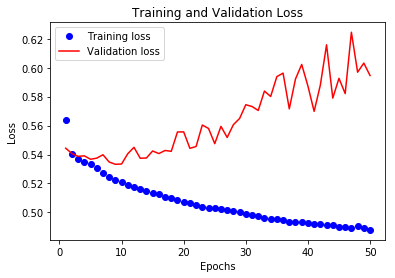

In [140]:
plot_loss(history.history['loss'], history.history['val_loss'])

In [0]:
import matplotlib.pyplot as plt

def plot_loss(loss, val_loss, N=1, ignore_initial=0, ignore_initial_val=0):
  loss = loss[ignore_initial:]
  val_loss = val_loss[ignore_initial_val:]

  loss = np.convolve(loss, np.ones((N,))/N, mode='valid')
  N_val = (len(val_loss)*N//len(loss))
  if N_val:
    val_loss = np.convolve(val_loss, np.ones((N_val,))/N_val, mode='valid')

  train_axis = (np.arange(1, len(loss) + 1) * (len(val_loss)/len(loss)))
  val_axis = np.arange(1, len(val_loss) + 1)

  plt.plot(train_axis, loss, 'bo', label='Training loss')
  plt.plot(val_axis, val_loss, 'r', label='Validation loss')

  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()